# Learning rate and gradient descent

How should we choose the learning rate for gradient? One way is to take a small part of the training set and to try different learning rates on the small part. Once a good learning rate is found, we use it on the whole training set. Even better is to dynamically adjust the learning rate while gradient descent is running. Because it's simpler, we stick here with constant learning rate.

In [1]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from matplotlib import ticker, cm
import math
import random
from sklearn.utils import shuffle

This is the standard gradient descent algorithm. By implementing different grad(x) methods we're going to use it for gradient descent, for SGD and for minibatch SGD.

In [2]:
def gradient_descent(grad,x0,eta,steps=10):
    path=[x0]
    x=x0
    for i in range(steps):
        x=x-eta*grad(x)
        path.append(x)
    return np.array(path)

## A random dataset for logistic regression

We generate a random dataset and apply logistic regression.

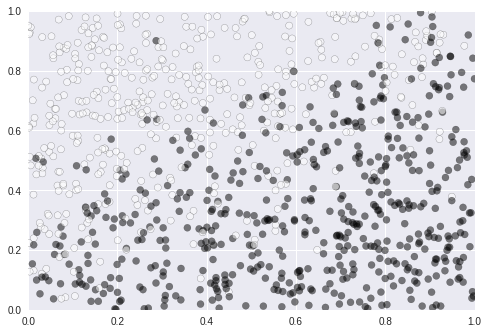

In [3]:
def logistic(z):
    return 1/(1+math.e**(-z))

def det_class(x):
    a,b=0.7,0.2
    d=a*x[0]+b-x[1]
    if random.random()<logistic(8*d):
        return 1
    return -1

def gen_samples(N):
    X=[(random.random(),random.random()) for i in range(N)]
    y=np.array([det_class(x) for x in X])
    X=np.array(X)
    return X,y

# generate data set, upper left -> class -1, lower right -> class 1

X,y=gen_samples(1000)
fig, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],c=y,alpha=0.5,edgecolor='k')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Next, we implement the logistic loss function as well as the gradient of logistic loss. Recall that logistic loss is defined as
$$
L(w)=\frac{1}{|S|}\sum_{(x,y)\in S}-\log\left(\frac{1}{1+e^{-y(w^Tx+b)}}\right)
$$
Note that we perform logistic regression with a bias term $b$.

In [4]:
def aff_fun(W,x):
    """returns sum W_ix_i+b, where b is the last entry of W"""
    return sum(W[:-1]*x)+W[-1]

# given data set, return logistic loss by weight vector
def log_reg_factory(X,y):
    def log_reg_loss(W):
        return 1/len(X)*sum([-math.log(logistic(y[i]*aff_fun(W,X[i,:])),2) for i in range(len(X))])
    return log_reg_loss

# given data set, return gradient of logistic loss 
def log_reg_grad_factory(X,y):
    def log_reg_grad(W):
        g0=sum([ -y[i]*X[i,0]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(len(X)) ])
        g1=sum([ -y[i]*X[i,1]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(len(X)) ])        
        g2=sum([ -y[i]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(len(X)) ])
        return np.array([g0,g1,g2])/len(X)/math.log(2) 
    return log_reg_grad

loss=log_reg_factory(X,y)
loss([1,2,3])

3.153323336218998

## Learning rate for ordinary gradient descent

We try different $\eta$ for gradient descent and plot the loss after 30 iterations. Why 30? Because 30 is not too small for gradient descent and also not too large that it takes forever.

Text(0.5, 1.0, 'learning rate with gradient descent')

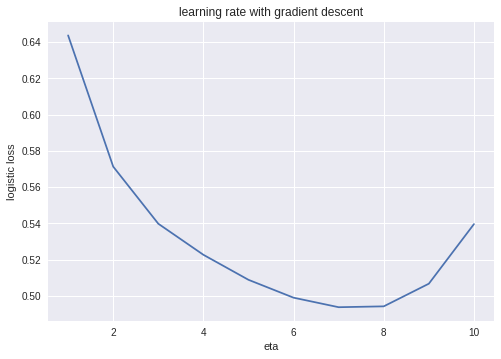

In [5]:
W0=[0,-1,0.1]
etas=np.linspace(1,10,10)
losses=np.ones(len(etas))
for i,eta in enumerate(etas):
    path=gradient_descent(log_reg_grad_factory(X,y),W0,eta,steps=30)
    losses[i]=loss(path[-1])
    
_,ax=plt.subplots()
ax.plot(etas,losses)
ax.set_xlabel('eta')
ax.set_ylabel('logistic loss')
ax.set_title('learning rate with gradient descent')

A learning rate $\eta\in[6,7]$ seems fine. Let's choose $\eta=6$. 

Just to get an impression how the loss looks like, we plot the loss of one run with $\eta=6$. 

Text(0.5, 1.0, 'gradient descent')

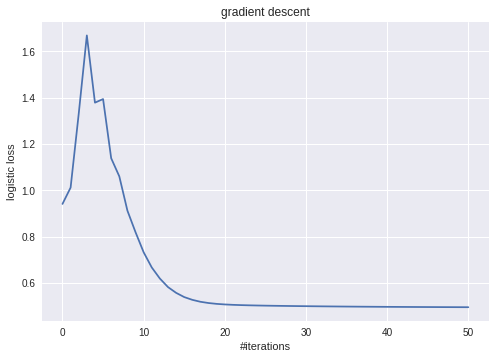

In [6]:
eta=6
path=gradient_descent(log_reg_grad_factory(X,y),W0,eta,steps=50)
_,ax=plt.subplots()
ax.plot(range(len(path)),[loss(p) for p in path])
ax.set_xlabel('#iterations')
ax.set_ylabel('logistic loss')
ax.set_title('gradient descent')

Looks fine.

## Learning rate for stochastic gradient descent

Let's do a more efficient implementation of (online) SGD this time. We only permute the dataset once at the beginning and then step through that random order repeatedly. Because we need to keep track of the current position in the dataset, I define a class here. 

To see how classes and objects work in python, have a look at the [documentation](https://docs.python.org/3/tutorial/classes.html) Section 9.3.

In [7]:
def stoch_grad_factory(X,y):
    # permute randomly
    X, y = sklearn.utils.shuffle(X,y)
    class Online:
        def __init__(self):
            self.i=0
    
        def subgrad(self,W):
            g0= -y[self.i]*X[self.i,0]*logistic(-y[self.i]*aff_fun(W,X[self.i,:]))
            g1= -y[self.i]*X[self.i,1]*logistic(-y[self.i]*aff_fun(W,X[self.i,:]))         
            g2= -y[self.i]*logistic(-y[self.i]*aff_fun(W,X[self.i,:]))
            self.i=(self.i+1)%len(y)
            return np.array([g0,g1,g2])/math.log(2) 
    return Online().subgrad

Because SGD is a random algorithm, we need to repeat for each $\eta$ several times to get some statistic stability. I chose to repeat each try 20 times, but it still looks jittery. I also take the average over the last ten losses to smoothen the losses a bit. 

Text(0.5, 1.0, 'learning rate with SGD')

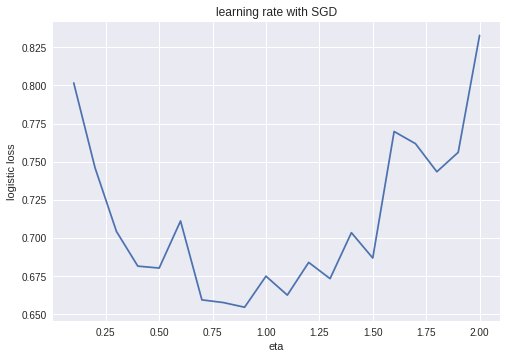

In [8]:
repeats=20
etas=np.linspace(0.1,2,20)
losses=np.ones(len(etas))
for i,eta in enumerate(etas):
    L=0
    for _ in range(repeats):
        path=gradient_descent(stoch_grad_factory(X,y),W0,eta,steps=100)
        L+=sum(loss(path[-i]) for i in range(10))/repeats/10
    losses[i]=L
_,ax=plt.subplots()
ax.plot(etas,losses)
ax.set_xlabel('eta')
ax.set_ylabel('logistic loss')
ax.set_title('learning rate with SGD')

A bit hard to tell but $\eta\in[0.3,0.8]$ is probably fine. Let's be prudent and take $\eta=0.1$. Again, let's do a test run with $\eta=0.1$. 

Text(0.5, 1.0, 'online SGD')

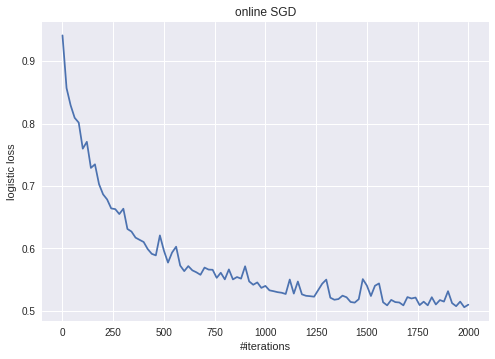

In [14]:
eta=0.1
path=gradient_descent(stoch_grad_factory(X,y),W0,eta,steps=2000)
## 2000 evaluations of the loss is time consuming -- let's do only 100 evaluations
slc=range(0,len(path),20)
losses=[loss(p) for p in path[slc]]
_,ax=plt.subplots()
ax.plot(slc,losses)
ax.set_xlabel('#iterations')
ax.set_ylabel('logistic loss')
ax.set_title('online SGD')

Learning rate seems fine. We should probably take the best choice of weights among the last 100 iterations or so (or perhaps the average).

## Minibatch SGD

For minibatch SGD we proceed in a similar way as for online SGD: we permute the dataset once at the beginning and then step through the dataset, only this time we always take size many datapoints at once and compute their gradient. Again, a class is used to keep track of the current position in the dataset.

In [10]:
def minibatch_grad_factory(X,y,size=10):
    """
    size: minibatch size, default = 10
    """
    X, y = sklearn.utils.shuffle(X,y)
    class Minibatcher:
        def __init__(self):
            self.minibatch=0
            
        def subgrad(self,W):
            start=self.minibatch*size
            end=min(len(y),(self.minibatch+1)*size)
            g0=sum([ -y[i]*X[i,0]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(start,end) ])
            g1=sum([ -y[i]*X[i,1]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(start,end) ])        
            g2=sum([ -y[i]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(start,end) ])
            if end==len(y):  # we're at the end of the dataset, so let's go back to the beginning
                self.minibatch=0
            else:
                self.minibatch+=1
            return np.array([g0,g1,g2])/size/math.log(2) 
    return Minibatcher().subgrad


Text(0.5, 1.0, 'learning rate with minibatch SGD')

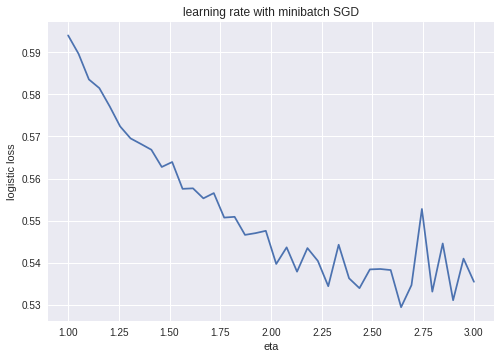

In [11]:
W0=[0,-1,0.1]
repeats=40
etas=np.linspace(1,3,40)
losses=np.ones(len(etas))
for i,eta in enumerate(etas):
    L=0
    for _ in range(repeats):
        path=gradient_descent(minibatch_grad_factory(X,y,size=20),W0,eta,steps=50)
        L+=loss(path[-1])/repeats
    losses[i]=L
    
_,ax=plt.subplots()
ax.plot(etas,losses)
ax.set_xlabel('eta')
ax.set_ylabel('logistic loss')
ax.set_title('learning rate with minibatch SGD')

A little bit inconclusive. I don't think that $\eta$ should be larger than $3$. Let's compare $\eta=3$ and $\eta=1$.

Text(0.5, 1.0, 'minibatch SGD, eta=3')

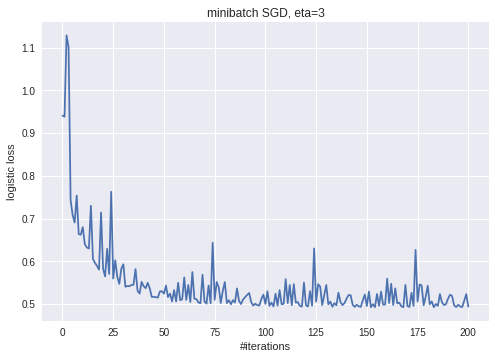

In [12]:
eta=3
path=gradient_descent(minibatch_grad_factory(X,y,size=20),W0,eta,steps=200)
_,ax=plt.subplots()
ax.plot(range(len(path)),[loss(p) for p in path])
ax.set_xlabel('#iterations')
ax.set_ylabel('logistic loss')
ax.set_title('minibatch SGD, eta={}'.format(eta))

Text(0.5, 1.0, 'minibatch SGD, eta=1')

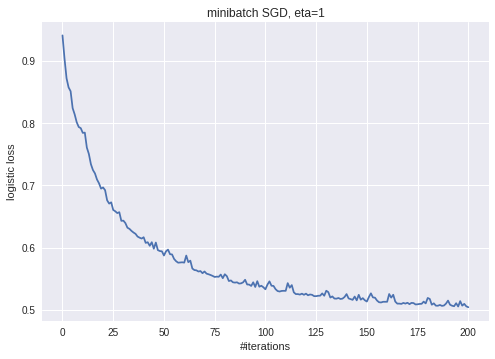

In [13]:
eta=1
path=gradient_descent(minibatch_grad_factory(X,y,size=20),W0,eta,steps=200)
_,ax=plt.subplots()
ax.plot(range(len(path)),[loss(p) for p in path])
ax.set_xlabel('#iterations')
ax.set_ylabel('logistic loss')
ax.set_title('minibatch SGD, eta={}'.format(eta))

Perhaps $\eta=1$ is fine. 